In [ ]:
# loval 61 structrue classification

In [1]:
import os, re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OPEN, CLOSE = "([{<", ")]}>"
PAIRMAP = dict(zip(OPEN + CLOSE, CLOSE + OPEN))

def read_dbn(dbn_path: str):
    dot = None
    with open(dbn_path, "r", encoding="utf-8", errors="ignore") as f:
        for ln in f:
            s = ln.strip()
            if not s or s.startswith(">"): 
                continue
            if set(s) <= set(".()[]{}<>"): # only characters used in dot-bracket 
                dot = s; break
    return dot

def build_pairs(dot: str):
    stacks = {ch: [] for ch in OPEN} # (), [], {}, <>
    partner = [-1] * len(dot)
    for i, ch in enumerate(dot):
        if ch in OPEN:
            stacks[ch].append(i)
        elif ch in CLOSE:
            op = PAIRMAP[ch] # matching opening stack
            if stacks[op]:
                j = stacks[op].pop()
                partner[i] = j; partner[j] = i
    return partner

def innermost_enclosing_pair(i, partner):
    bestL = bestR = -1
    for L, R in enumerate(partner):
        if R > L and L < i < R and L > bestL:
            bestL, bestR = L, R
    return bestL, bestR

def top_level_inner_pairs(L, R, partner):
    opens, depth = [], 0
    for k in range(L+1, R):
        p = partner[k]
        if p == -1: 
            continue
        if k < p:
            if depth == 0: opens.append(k)
            depth += 1
        else:
            depth -= 1
    return opens

def classify_site(dot, i, partner):
    if partner[i] != -1: return "S"   # Stem
    L, R = innermost_enclosing_pair(i, partner) # Scan all pairs -- keep the tightest one around i
    if L == -1: return "E"            # Exterior
    inner = top_level_inner_pairs(L, R, partner)
    if len(inner) == 0: return "H"    # Hairpin
    if len(inner) >= 2: return "M"    # Multiloop
    l2 = inner[0]; r2 = partner[l2]
    if r2 < l2: l2, r2 = r2, l2
    left_unp  = l2 - (L + 1)
    right_unp = (R - 1) - r2
    return "B" if (left_unp == 0) ^ (right_unp == 0) else "I"  # Bulge vs Internal

def canonical_id(name: str):
    base = Path(name).name
    base = re.sub(r'\.(dbn|ct|csv|tsv|txt)$', '', base, flags=re.I)
    base = re.sub(r'_(zeroshot|finetune)_prediction$', '', base, flags=re.I)
    return base

def index_dbn_files(dbn_root: str, zeroshot_only=True):
    idx = {}
    for rp, _, files in os.walk(dbn_root):
        for fn in files:
            low = fn.lower()
            if not low.endswith(".dbn"): 
                continue
            if zeroshot_only and ("zeroshot" not in low or "finetune" in low):
                continue
            cid = canonical_id(fn)
            idx[cid] = os.path.join(rp, fn)
    return idx

def assay_from_path(dbn_root: str, dbn_path: str):
    rel = os.path.relpath(dbn_path, dbn_root)
    first = rel.split(os.sep, 1)[0] if os.sep in rel else rel
    return re.sub(r'(_|-)(pos|neg|positive|negative)$', '', first, flags=re.I) or first or "all"



In [2]:
from pathlib import Path
import os, re
import pandas as pd

# ---- CONFIG ----
FEATURES_CSV = "bprna_ernie_features3.csv"
DBN_ROOT = Path("db_output")   
POS1 = 61 # 1-based site (center of 121-nt windows)
FLANK = 0   # 0 = exact site


# check name "db_output"
if not DBN_ROOT.is_dir():
    alt = Path("db_output")
    if alt.is_dir():
        DBN_ROOT = alt
    else:
        raise FileNotFoundError(
            f"Neither '{Path('dp_output').resolve()}' nor '{alt.resolve()}' exists. "
            "Set DBN_ROOT to your folder that holds the assay subfolders")

print("FEATURES_CSV:", Path(FEATURES_CSV).resolve())
print("DBN_ROOT:", DBN_ROOT.resolve())

# quick look at subfolders  and a few .dbn files -zeroshot only- 
assay_dirs = [d for d in DBN_ROOT.iterdir() if d.is_dir()]
print("Assay folders found:", [d.name for d in assay_dirs[:10]])

# count zeroshot dbns 
n_dbn = 0
some = []
for rp, _, files in os.walk(DBN_ROOT):
    for fn in files:
        low = fn.lower()
        if low.endswith(".dbn") and ("zeroshot" in low) and ("finetune" not in low):
            n_dbn += 1
            if len(some) < 5:
                some.append(os.path.join(rp, fn))
print(f"Zeroshot .dbn files detected: {n_dbn}")
for s in some: print("  -", s)


FEATURES_CSV: /nobackup/tjxz93/pse_project/bprna_ernie_features3.csv
DBN_ROOT: /nobackup/tjxz93/pse_project/db_output
Assay folders found: ['hek_csv_neg', 'hk_qp', 'bid_seq_neg', 'pseudo_seq_pos', 'hk_qp_neg', 'hek_csv_pos', 'bid_seq_pos', '.ipynb_checkpoints', 'pseudo_seq_neg']
Zeroshot .dbn files detected: 1368
  - db_output/hek_csv_neg/ENST00000513613:122343360-122343480(+)_zeroshot_prediction.dbn
  - db_output/hek_csv_neg/ENST00000420826:73178913-73179033(-)_zeroshot_prediction.dbn
  - db_output/hek_csv_neg/ENST00000428183:102739341-102739461(+)_zeroshot_prediction.dbn
  - db_output/hek_csv_neg/ENST00000392595:134123118-134123238(-)_zeroshot_prediction.dbn
  - db_output/hek_csv_neg/ENST00000643447:112566556-112566676(-)_zeroshot_prediction.dbn


In [3]:
# --- classify the site pos1 = 61 and viz ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import re  

i0 = POS1 - 1

def majority_shape(dot, i0, w, partner):
    if w <= 0:
        return None
    lo = max(0, i0 - w); hi = min(len(dot) - 1, i0 + w)
    votes = [classify_site(dot, j, partner) for j in range(lo, hi+1)]
    return Counter(votes).most_common(1)[0][0] if votes else None

# binary label mapping
df = pd.read_csv(FEATURES_CSV)
df = df.loc[:, ~df.columns.str.contains(r"^Unnamed", case=False)]
lab = df["label"].astype(str).str.lower().str.strip()
df["label_text"] = lab
df["label"] = np.select(
    [
        lab.eq("hk_qp") | lab.str.contains(r'(?:^|[_-])pos(?:itive)?(?:$|[_-])'),
        lab.eq("hk_qp_neg") | lab.str.contains(r'(?:^|[_-])neg(?:ative)?(?:$|[_-])'),
    ],
    [1, 0],
    default=np.nan
)  # keep as float with NaN

# clean string label for grouping
df["pus7"] = np.where(df["label"] == 1, "pos",
               np.where(df["label"] == 0, "neg", np.nan))

print("pus7 from feature file:", df["pus7"].value_counts(dropna=False).to_dict())

# index zeroshot dbns
dbn_index = index_dbn_files(DBN_ROOT, zeroshot_only=True)

def posneg_from_path(dbn_root, dbn_path):
    try:
        first = Path(dbn_path).resolve().relative_to(Path(dbn_root).resolve()).parts[0].lower()
    except Exception:
        first = Path(dbn_path).parent.name.lower()
    if re.search(r'(?:^|[_-])pos(?:itive)?$', first): return "pos"
    
    if re.search(r'(?:^|[_-])neg(?:ative)?$', first): return "neg"
    return None

rows, missing = [], 0
for _, r in df.iterrows():
    sid = str(r["sample_id"])
    cid = canonical_id(sid)
    path = dbn_index.get(cid)
    if path is None:
        hits = [p for k,p in dbn_index.items() if k == cid or k.startswith(cid)]
        path = hits[0] if hits else None
    if path is None:
        missing += 1; continue

    dot = read_dbn(path) # 
    if not dot or not (0 <= i0 < len(dot)):
        missing += 1; continue

    partner = build_pairs(dot)
    center  = classify_site(dot, i0, partner)

    major   = majority_shape(dot, i0, FLANK, partner) or center
    assay   = assay_from_path(DBN_ROOT, path)

    # fill pus7 from feature file OR folder name
    pus7 = r.get("pus7")
    if pd.isna(pus7):
        pus7 = posneg_from_path(DBN_ROOT, path)

    rows.append({
        "sample_id": sid,
        "assay": assay,
        "pus7": pus7,             
        "site_shape_center": center,
        "site_shape_majority": major
    })

print(f"unmatched/invalid samples skipped: {missing}")

ctx_df = pd.DataFrame(rows)
use_col = "site_shape_center" if FLANK == 0 else "site_shape_majority"
ctx = ctx_df.rename(columns={use_col: "site_shape"}).dropna(subset=["pus7"])

# counts & fractions by assay × PUS7
counts = (ctx.groupby(["assay","pus7","site_shape"])
            .size().reset_index(name="count"))
totals = counts.groupby(["assay","pus7"])["count"].sum().rename("total")
counts = counts.merge(totals, on=["assay","pus7"])
counts["fraction"] = counts["count"] / counts["total"]

# save & plot
outdir = Path("site_context_out"); outdir.mkdir(exist_ok=True)
ctx.to_csv(outdir/"site_contexts2.csv", index=False)

counts.sort_values(["assay","pus7","site_shape"]).to_csv(
    outdir/"site_context_distribution_by_assay_pus7_2.csv", index=False)


pus7 from feature file: {'neg': 1039, 'pos': 329}
unmatched/invalid samples skipped: 0


In [4]:

# checks

print("pus7 counts:", ctx["pus7"].value_counts(dropna=False).to_dict())
print("assays:", sorted(ctx["assay"].unique()))
print(counts.head())


pus7 counts: {'neg': 1039, 'pos': 329}
assays: ['bid_seq', 'hek_csv', 'hk_qp', 'pseudo_seq']
     assay pus7 site_shape  count  total  fraction
0  bid_seq  neg          E      4     34  0.117647
1  bid_seq  neg          H     22     34  0.647059
2  bid_seq  neg          I      5     34  0.147059
3  bid_seq  neg          M      2     34  0.058824
4  bid_seq  neg          S      1     34  0.029412


/local/slurm.14550590/ipykernel_4158414/375906726.py:65: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(right=0.82)  # space for legend


saved: site_context_out/shape_site_assay.png


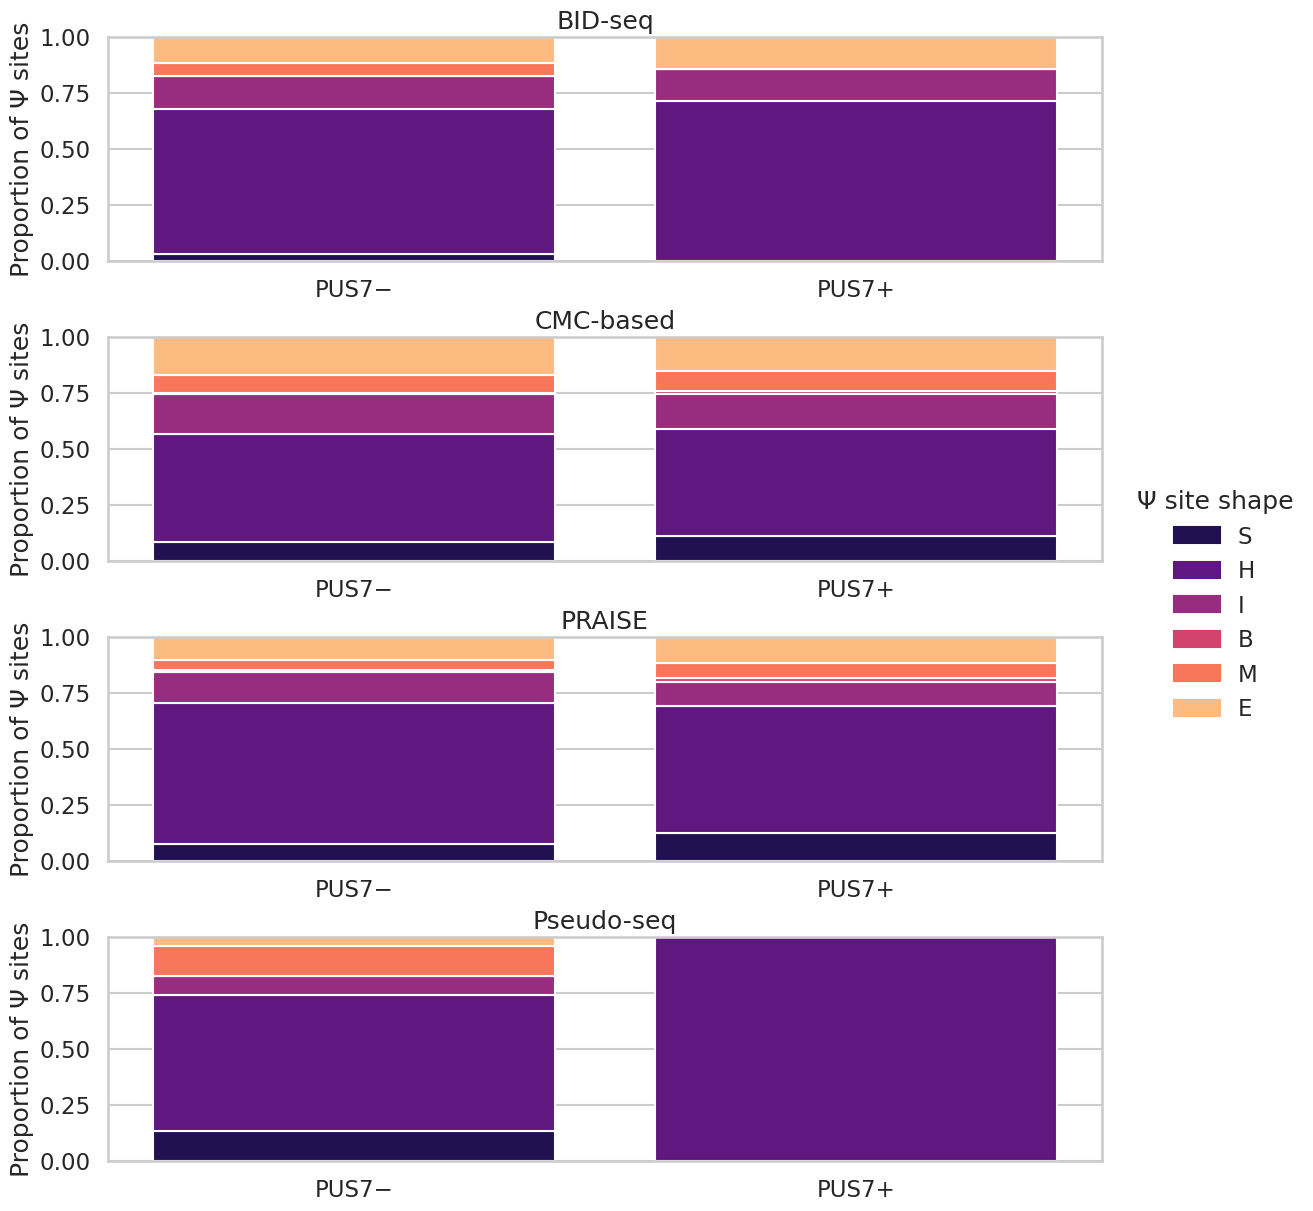

In [20]:

import seaborn as sns
import matplotlib.patches as mpatches

# output
outdir = Path("site_context_out"); outdir.mkdir(exist_ok=True)
out_png = outdir / "shape_site_assay.png"


# shapes first
shapes = ["S","H","I","B","M","E"]
assays = sorted(ctx["assay"].unique())

# seaborn styling + colors
sns.set_theme(context="talk", style="whitegrid")

palette = sns.color_palette("magma", n_colors=len(shapes))

color_map = dict(zip(shapes, palette))

# Pretty titles for assays
ASSAY_TITLE_MAP = {
    "bid_seq":     "BID-seq",
    "hek_csv":     "CMC-based",
    "hk_qp":       "PRAISE",
    "pseudo_seq":  "Pseudo-seq",
}

def assay_title(name: str) -> str:
    return ASSAY_TITLE_MAP.get(name, name.replace("_", " ").title())

# plot stacked bars per assay
fig, axes = plt.subplots(len(assays), 1, figsize=(11, 3.0*len(assays)), constrained_layout=True)
if len(assays) == 1:
    axes = [axes]

for ax, assay in zip(axes, assays):
    sub = counts[counts["assay"] == assay]
    piv = (sub.pivot(index="pus7", columns="site_shape", values="fraction")
              .reindex(index=["neg","pos"]))
    piv = piv.reindex(columns=shapes).fillna(0.0)

    bottom = np.zeros(len(piv))
    x = np.arange(len(piv))  # 0: neg, 1: pos

    for s in shapes:
        vals = piv[s].values if s in piv.columns else np.zeros_like(bottom)
        ax.bar(x, vals, bottom=bottom, label=s, color=color_map[s])
        bottom += vals

    ax.set_title(assay_title(assay))
    ax.set_xticks(x); ax.set_xticklabels(["PUS7−","PUS7+"])
    ax.set_ylabel("Proportion of Ψ sites")
    ax.set_ylim(0, 1.0)
    # remove  per-axis legend - shared one
    leg = ax.get_legend()
    if leg:
        leg.remove()

# shared legend on the right
legend_handles = [mpatches.Patch(color=color_map[s], label=s) for s in shapes]
fig.legend(legend_handles, [s for s in shapes], title="Ψ site shape",
           loc="center left", bbox_to_anchor=(1.01, 0.5), frameon=False)

plt.subplots_adjust(right=0.82)  # space for legend
fig.savefig(out_png, dpi=300, bbox_inches="tight", facecolor="white")
print("saved:", out_png)
plt.show()



In [ ]:
# to get the significance
# avoid row sum 0 for X^2 test
# the chisqr 6×2 omnibus test checks the entire site-shape distribution (6 shapes × 2 groups: PUS7+ vs PUS7-) within each assay


In [7]:
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests

shapes = ["S","H","I","B","M","E"]

# Omnibus chisqr per assay - drop empty 
omni_rows = []
for assay, sub in counts.groupby("assay"):
    tab = (sub.pivot(index="site_shape", columns="pus7", values="count")
             .reindex(index=shapes, columns=["neg","pos"]).fillna(0).astype(int))

    # drop shapes absent in both groups; drop any empty
    tab = tab.loc[tab.sum(axis=1) > 0, :]
    tab = tab.loc[:, tab.sum(axis=0) > 0]

    # if fewer than 2 non-empty rows remain, chisqr is not defined
    if tab.shape[0] < 2:
        omni_rows.append({"assay": assay, "test": "chi2_6x2", "p": np.nan,
                          "chi2": np.nan, "dof": np.nan, "n": int(tab.values.sum()),
                          "note": "skipped: <2 non-empty shapes"})
        continue
    
    chi2, p, dof, expected = chi2_contingency(tab.values, correction=False)
    omni_rows.append({"assay": assay, "test": "chi2_6x2", "p": p, "chi2": chi2,
                      "dof": dof, "n": int(tab.values.sum()),
                      "min_expected": float(expected.min())})

omnibus = pd.DataFrame(omni_rows)
if not omnibus.empty and omnibus["p"].notna().any():
    omnibus["q"] = multipletests(omnibus["p"].fillna(1.0), method="fdr_bh")[1]

print("Omnibus (6x2) by assay") # Chi-square
print(omnibus.sort_values(["p"], na_position="last"))


Omnibus (6x2) by assay
        assay      test         p      chi2  dof    n  min_expected         q
2       hk_qp  chi2_6x2  0.332637  5.737195    5  674      1.234421  0.852125
3  pseudo_seq  chi2_6x2  0.577542  2.883295    4   28      0.178571  0.852125
1     hek_csv  chi2_6x2  0.763880  2.583439    5  618      2.000000  0.852125
0     bid_seq  chi2_6x2  0.852125  1.354142    4   48      0.291667  0.852125
